In [1]:
import os
from pathlib import Path
from datetime import datetime, timedelta
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def get_fred_data(series_id, api_key, start_date=None, end_date=None, frequency='q', units='lin'):
    """
    Retrieve economic data from the FRED API
    
    Parameters:
    -----------
    series_id : str
        FRED series ID (e.g., 'GDP', 'GDPC1')
    api_key : str
        Your FRED API key
    start_date : str, optional
        Start date in format 'YYYY-MM-DD'
    end_date : str, optional
        End date in format 'YYYY-MM-DD'
    frequency : str, optional
        Data frequency: 'd' (daily), 'w' (weekly), 'm' (monthly), 'q' (quarterly), 'a' (annual)
    units : str, optional
        Units transformation: 'lin' (levels), 'chg' (change), 'pch' (percent change)
        
    Returns:
    --------
    pandas.DataFrame with the requested data
    """
    # Base URL for the FRED API
    base_url = "https://api.stlouisfed.org/fred/series/observations"
    
    # Set up parameters
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'frequency': frequency,
        'units': units
    }
    
    # Add date range if specified
    if start_date:
        params['observation_start'] = start_date
    if end_date:
        params['observation_end'] = end_date
    
    # Make the API request
    response = requests.get(base_url, params=params)
    
    # Check if the request was successful
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None
    
    # Convert response to DataFrame
    data = response.json()
    df = pd.DataFrame(data['observations'])
    
    # Process the data
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    
    # Set date as index and drop unnecessary columns
    df = df.set_index('date')
    if 'realtime_start' in df.columns:
        df = df.drop(['realtime_start', 'realtime_end'], axis=1)
    
    # Rename the 'value' column to the series_id for clarity
    df = df.rename(columns={'value': series_id})
    
    return df

In [3]:
def get_series_info(series_id, api_key):
    """Get detailed information about a FRED series"""
    url = "https://api.stlouisfed.org/fred/series"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json'
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        return response.json()['seriess'][0]
    else:
        print(f"Error getting series info: {response.status_code}")
        return None

In [5]:
# Replace with your actual API key from https://fred.stlouisfed.org/docs/api/api_key.html
API_KEY = "b85eb30e34abc01edd5b64c248bb945b"

# Set the date range (last 10 years)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*1)).strftime('%Y-%m-%d')

# Define GDP series to retrieve
gdp_series = {
    'GDP': 'Nominal GDP',
    'GDPC1': 'Real GDP (2017 dollars)',
    'A191RP1Q027SBEA': 'GDP Growth Rate'
}

In [6]:
# Create an empty DataFrame to store all series
all_data = pd.DataFrame()

# Fetch each series and add to the DataFrame
for series_id, description in gdp_series.items():
    # Get series metadata
    series_info = get_series_info(series_id, API_KEY)
    if series_info:
        print(f"\nSeries: {description}")
        print(f"Title: {series_info['title']}")
        print(f"Units: {series_info['units']}")
        print(f"Frequency: {series_info['frequency_short']}")
        
        # Set appropriate units based on the series
        units = 'lin'  # Default to levels
        if series_id == 'A191RP1Q027SBEA':
            units = 'lin'  # This is already a percent change series
        
        # Get the data
        df = get_fred_data(
            series_id=series_id,
            api_key=API_KEY,
            start_date=start_date,
            end_date=end_date,
            frequency='q',  # Quarterly data
            units=units
        )
        
        if df is not None:
            # Add to the combined DataFrame
            if all_data.empty:
                all_data = df
            else:
                all_data = all_data.join(df, how='outer')
            
            # Show the first and last few rows
            print("\nFirst few observations:")
            print(df.head(3))
            print("\nLast few observations:")
            print(df.tail(3))


Series: Nominal GDP
Title: Gross Domestic Product
Units: Billions of Dollars
Frequency: Q

First few observations:
                  GDP
date                 
2024-01-01  28624.069
2024-04-01  29016.714
2024-07-01  29374.914

Last few observations:
                  GDP
date                 
2024-04-01  29016.714
2024-07-01  29374.914
2024-10-01  29719.647

Series: Real GDP (2017 dollars)
Title: Real Gross Domestic Product
Units: Billions of Chained 2017 Dollars
Frequency: Q

First few observations:
                GDPC1
date                 
2024-01-01  23053.545
2024-04-01  23223.906
2024-07-01  23400.294

Last few observations:
                GDPC1
date                 
2024-04-01  23223.906
2024-07-01  23400.294
2024-10-01  23536.293

Series: GDP Growth Rate
Title: Gross Domestic Product
Units: Percent Change from Preceding Period
Frequency: Q

First few observations:
            A191RP1Q027SBEA
date                       
2024-01-01              4.7
2024-04-01              5.6
2

In [8]:
# Fill NaN values with forward fill for visualization
all_data = all_data.ffill()

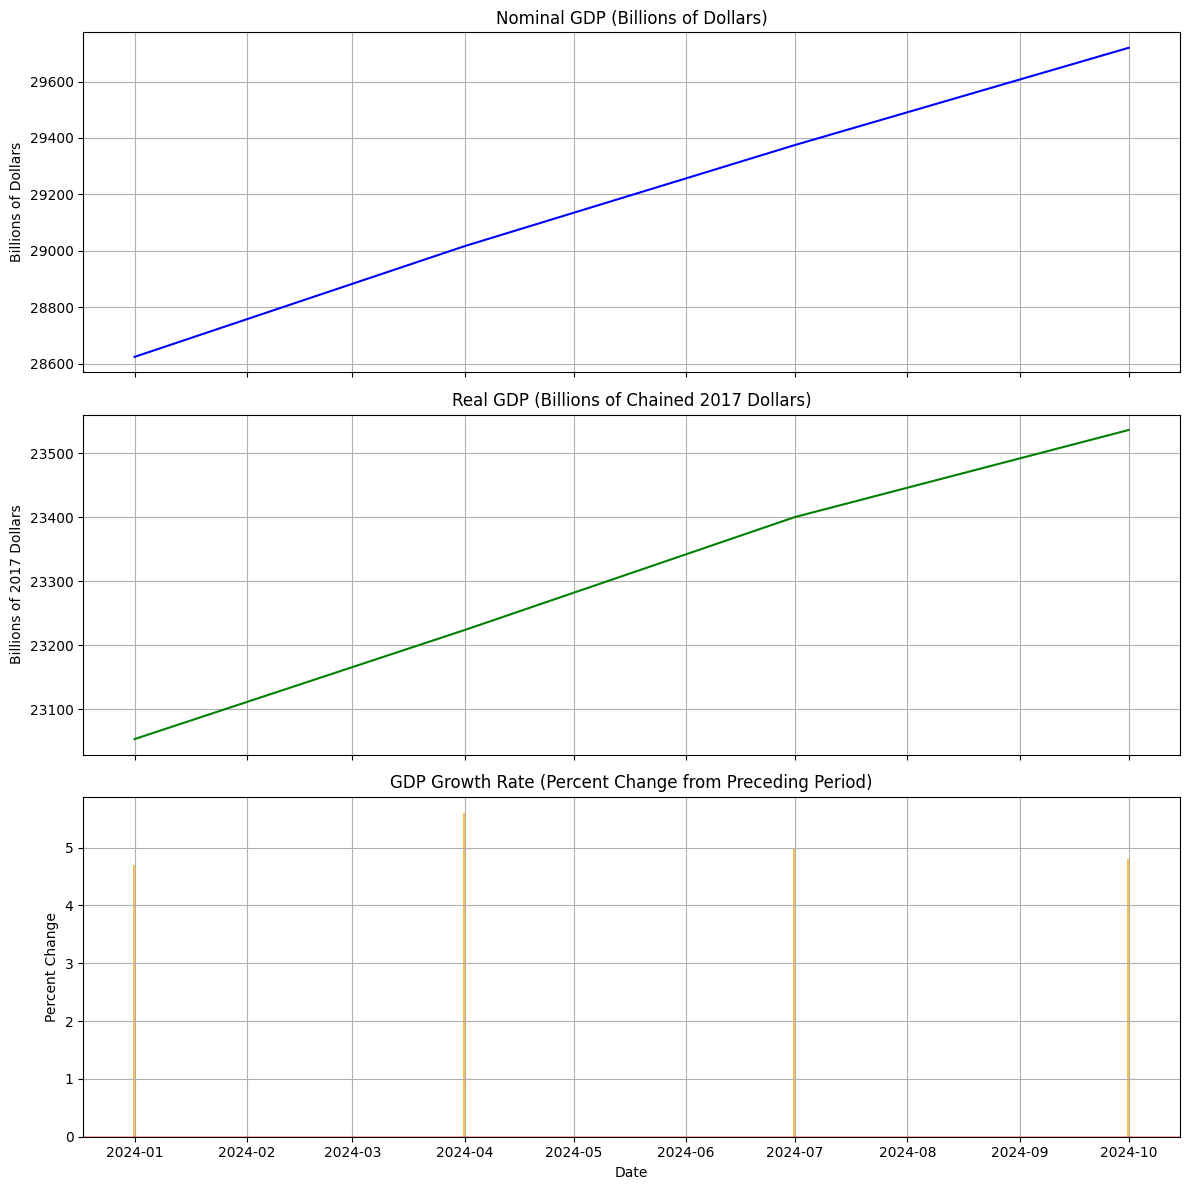

In [9]:
# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot Nominal GDP
if 'GDP' in all_data.columns:
    axes[0].plot(all_data.index, all_data['GDP'], 'b-')
    axes[0].set_title('Nominal GDP (Billions of Dollars)')
    axes[0].grid(True)
    # Format y-axis to show billions
    axes[0].set_ylabel('Billions of Dollars')

# Plot Real GDP
if 'GDPC1' in all_data.columns:
    axes[1].plot(all_data.index, all_data['GDPC1'], 'g-')
    axes[1].set_title('Real GDP (Billions of Chained 2017 Dollars)')
    axes[1].grid(True)
    axes[1].set_ylabel('Billions of 2017 Dollars')

# Plot GDP Growth Rate
if 'A191RP1Q027SBEA' in all_data.columns:
    axes[2].bar(all_data.index, all_data['A191RP1Q027SBEA'], color='orange', alpha=0.7)
    axes[2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
    axes[2].set_title('GDP Growth Rate (Percent Change from Preceding Period)')
    axes[2].grid(True)
    axes[2].set_ylabel('Percent Change')

# Set common x-axis label
axes[2].set_xlabel('Date')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
# Print some basic statistics
if not all_data.empty:
    print("\nBasic Statistics:")
    print(all_data.describe())